# Introduction to plotting

* **Prerequisites:** Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_Jupyter_notebooks.ipynb)
    * Inspecting available [Products and measurements](02_Products_and_measurements.ipynb)
    * How to [load data](03_Loading_data.ipynb)

## Background
Data visualisation is an important component of working with Earth Observation data.
The `xarray` Python package provides a range of straightforward data plotting options which allow users to quickly generate simple plots from multi-dimensional datasets. 

## Description
This introductory notebook demonstrates how to visualise satellite data returned from running a datacube query.
The notebook demonstrates commonly used `xarray` plotting methods, as well as custom functions provided in the [deafrica_plotting](../Scripts/deafrica_plotting.py) script.

Topics covered in this notebook include:

* View your area of interest prior to querying the datacube
* Querying the datacube and loading data
* Plotting single band data (e.g. a single satellite band)
    * Selecting and plotting individual timesteps
    * Plotting multiple timesteps
    * Customising plot appearance
* Plotting three-band true or false colour imagery
    * Plotting single timesteps
    * Plotting multiple timesteps
    * Customising plot appearance

***

## Getting started
To run this introduction to plotting data loaded from the datacube, run all the cells in the notebook starting with the "Load packages" cell. For help with running notebook cells, refer back to the [Jupyter Notebooks notebook](01_Jupyter_notebooks.ipynb). 

### Load packages
First we run `%matplotlib inline`, which ensures figures plot correctly in the Jupyter notebook.

We then need to load the `datacube` package, which allows us to load some data and a selection of custom functions from the `deafrica_plotting` script. The `deafrica_plotting` script is located inside the `../Scripts folder`.

In order to use the custom fuctions on the sandbox, we need to add that folder location to the python path. We achieve this using `sys.path.append()` to add the `../Scripts` folder containing the `deafrica_plotting` python file to the python path. The two custom fuctions `display_map()` and `rgb()` are then imported form the `deafrica_plotting` python file.

In [2]:
%matplotlib inline

import datacube
import sys
import xarray as xr

sys.path.append("../Scripts")
from deafrica_plotting import display_map
from deafrica_plotting import rgb

from datacube.utils import geometry, masking

ModuleNotFoundError: No module named 'deafrica_plotting'

### Connect to the datacube
We then connect to the datacube database so we can load data. 

In [ ]:
dc = datacube.Datacube(app="04_Plotting")

### Analysis parameters

The following variables are required to establish a query for this notebook:
- `lat_range`: The latitude range to analyse (e.g. `(-32, -28.73)`).
- `lon_range`: The longitude range to analyse (e.g. `(-71.5, -70.3)`).
- `time_range`: The date range to analyse (e.g. `("2020-01-01", "2020-03-30")`).


In [102]:
lat_range = (-30, -29.8)
lon_range = (-71.4, -71.2)
time_range = ("2020-01-01", "2020-06-30")

## View the queried location
Before running a query and extracting and analysing data, it is useful to double-check that your location is correct.
The `display_map()` function shows your selected area as a red rectangle on an interactive map.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [103]:
display_map(x=lon_range, y=lat_range)

## Query and view data
The variables determined above are used here to query the DE Africa datacube using the `dc.load()` function and load data introduced in the [Loading data notebook](04_Loading_data.ipynb).
This introduction will to use Landsat 8 Surface reflectance `ls8_usgs_sr_scene`.

In [104]:
ds = dc.load(product="usgs_espa_ls8c1_sr",
             measurements=['blue','green','red','nir','swir1','swir2'],
             x=lon_range,
             y=lat_range,
             time=time_range,
             output_crs='EPSG:32719',
             resolution=(-30, 30),
             dask_chunks={"time": 1})

ds

<xarray.Dataset>
Dimensions:      (time: 24, x: 659, y: 753)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:38:52.513207 ... 2020-06-25T14:38:47.721342
  * y            (y) float64 6.701e+06 6.701e+06 ... 6.679e+06 6.679e+06
  * x            (x) float64 2.68e+05 2.681e+05 ... 2.877e+05 2.878e+05
    spatial_ref  int32 32719
Data variables:
    blue         (time, y, x) int16 dask.array<chunksize=(1, 753, 659), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(1, 753, 659), meta=np.ndarray>
    red          (time, y, x) int16 dask.array<chunksize=(1, 753, 659), meta=np.ndarray>
    nir          (time, y, x) int16 dask.array<chunksize=(1, 753, 659), meta=np.ndarray>
    swir1        (time, y, x) int16 dask.array<chunksize=(1, 753, 659), meta=np.ndarray>
    swir2        (time, y, x) int16 dask.array<chunksize=(1, 753, 659), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

## Remove null data and empty scenes
In order to work with real data, it is important to remove null values and remove empty scenes which might overlap with the requested bounding box. The code below handles both of these, but the detail of this is covered in another notebook. See (TBA).

In [105]:
nans = masking.mask_invalid_data(ds)
nans = ds.update(nans)

nulls = ds.red.isnull()
grid_size = len(ds.x) * len(ds.y)
null_perc = nulls.where(nulls).count(dim=["x", "y"]) / grid_size
ds["null_perc"] = xr.DataArray(null_perc, [("time", ds.time)])
ds = ds.sel(time=ds.null_perc < 0.9)

## Plotting single band images

The `xarray` package provides built-in methods for plotting individual data variables or measurements.
For example, we might want to make a plot for a single measurement like the `swir1` satellite band in the data we loaded above.

To do this, we first need to access the band we are after as an `xarray.DataArray` (to revise the difference between `xarray.Dataset` and `xarray.DataArray` objects, refer back to the [Loading data](04_Loading_data.ipynb) notebook):

In [106]:
ds.swir1

<xarray.DataArray 'swir1' (time: 12, y: 753, x: 659)>
dask.array<getitem, shape=(12, 753, 659), dtype=float64, chunksize=(1, 753, 659), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:39:16.459314 ... 2020-06-25T14:38:47.721342
  * y            (y) float64 6.701e+06 6.701e+06 ... 6.679e+06 6.679e+06
  * x            (x) float64 2.68e+05 2.681e+05 ... 2.877e+05 2.878e+05
    spatial_ref  int32 32719
Attributes:
    units:         reflectance
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

### Selecting and plotting a single timestep

You can see in the object header that this `xarray.DataArray` has data for twenty-four timesteps (i.e. see above where it says: `xarray.DataArray 'swir1' (time: 12 y: 1881 x: 1651)`). To make a plot for a single timestep only, we need to select it using one of the following options:

1. `.isel()`: This stands for "index selection", and lets us easily select individual timesteps from a dataset by providing the number of the observation we want. 
Counting in Python begins at 0, so to select the first timestep in the `xarray.DataArray` we can specify `.isel(time=0)`:

In [107]:
first_timestep = ds.swir1.isel(time=0)

first_timestep

<xarray.DataArray 'swir1' (y: 753, x: 659)>
dask.array<getitem, shape=(753, 659), dtype=float64, chunksize=(753, 659), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2020-01-01T14:39:16.459314
  * y            (y) float64 6.701e+06 6.701e+06 ... 6.679e+06 6.679e+06
  * x            (x) float64 2.68e+05 2.681e+05 ... 2.877e+05 2.878e+05
    spatial_ref  int32 32719
Attributes:
    units:         reflectance
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

2. `.sel()`: This allows us to select data using real-world coordinate labels like `time`. 
    For example, from the *Coordinates* section, we can select the first timestep (i.e. The observation for January 6th 2017) from the `xarray.DataArray` by specifying `.sel(time='2020-01-01')`:

In [108]:
first_timestep = ds.swir1.sel(time='2020-01-01')

first_timestep

<xarray.DataArray 'swir1' (time: 1, y: 753, x: 659)>
dask.array<getitem, shape=(1, 753, 659), dtype=float64, chunksize=(1, 753, 659), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:39:16.459314
  * y            (y) float64 6.701e+06 6.701e+06 ... 6.679e+06 6.679e+06
  * x            (x) float64 2.68e+05 2.681e+05 ... 2.877e+05 2.878e+05
    spatial_ref  int32 32719
Attributes:
    units:         reflectance
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

We can now use the `.plot()` method to plot `swir1` data for our selected timestep:

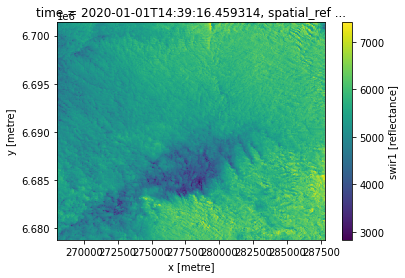

In [109]:
first_timestep.plot()

As you can see, this seen is completely covered in cloud!

### Plotting multiple timesteps
It is often useful to produce plots for a single measurement across time, for example to compare change between satellite observations or summary datasets.
To plot multiple images, we can skip the `isel()` step above and plot the entire `xarray.DataArray` directly. 

To plot multiple timesteps in one figure, we need to tell the `.plot()` function to put each timestep in a different column.
We can do this by specifying `.plot(col="time")`:

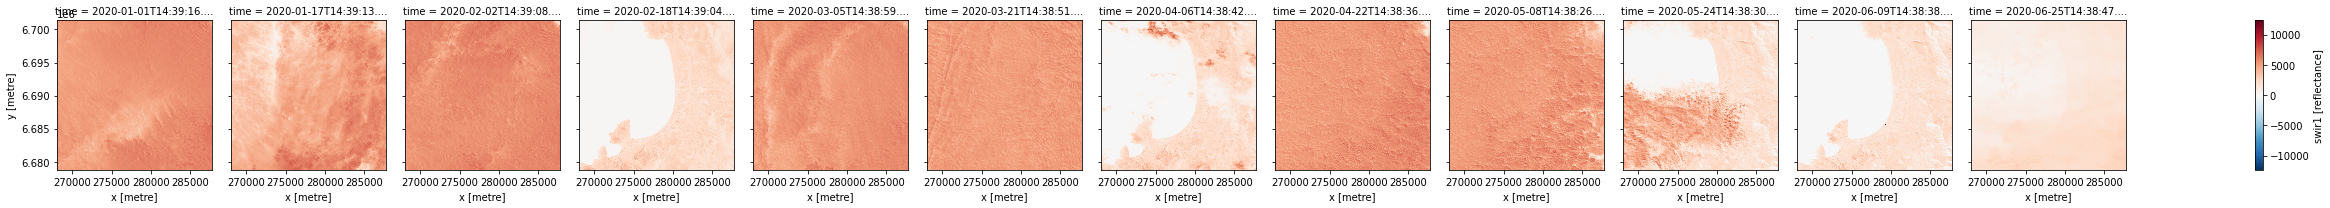

In [114]:
ds.swir1.plot(col="time")

> **Note**: This kind of plotting is called "facetted plotting". For more information, refer to the [xarray documentation](http://xarray.pydata.org/en/stable/plotting.html#faceting)

### Customising plot appearance
You may notice that the plots above are dark and difficult to see clearly.
To improve the appearance of `xarray` plots, you can use the `robust=True` argument to optimise the plot colours by clipping extreme values or outliers. 
This will use the 2nd and 98th percentiles of the data to compute the color limits:

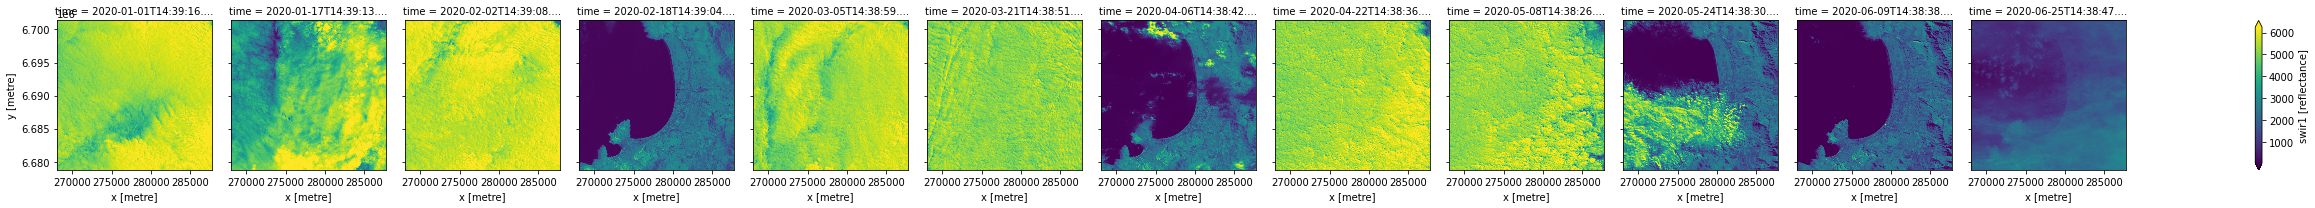

In [115]:
ds.swir1.plot(col="time", robust=True)

We can also easily use custom colour maps/styles to visualise our data using the `cmap` parameter.

When choosing a colour map for a plot, it is important to choose a set of colours that are perceived logically by the human eye. 
The best colour maps are "perceptually uniform": these colour maps increase logically from dark to light colours, where equal increases in lightness/darkness correspond to equal changes in data values. 
Some best-practice perceptually uniform colour maps include:

```
"viridis", "plasma", "inferno", "magma", "cividis"
```

> **Note**: For further reading about perceptually uniform colour maps in data visualisation, refer to the [matplotlib documentation](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

It is also important to consider colour blindness when selecting a colour map. 
`xarray` supports many colour maps from the "colorbrewer" family of colour maps which are optimised for colour blindness.
You can use the interactive [online tool](http://colorbrewer2.org) to browse all available colour maps, or choose from one of the following commonly used options:

```
"Greys", "Purples", "Blues", "Greens", "Oranges", "Reds",
"YlOrBr", "YlOrRd", "OrRd", "PuRd", "RdPu", "BuPu", 
"GnBu", "PuBu", "YlGnBu", "PuBuGn", "BuGn", "YlGn"
```

For a full list of available colour maps you can refer to [this list](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).

For example, to plot our data with the perceptually uniform `magma` colour map. Note that we are also using the `col_wrap` variable to only plot four scenes per row:


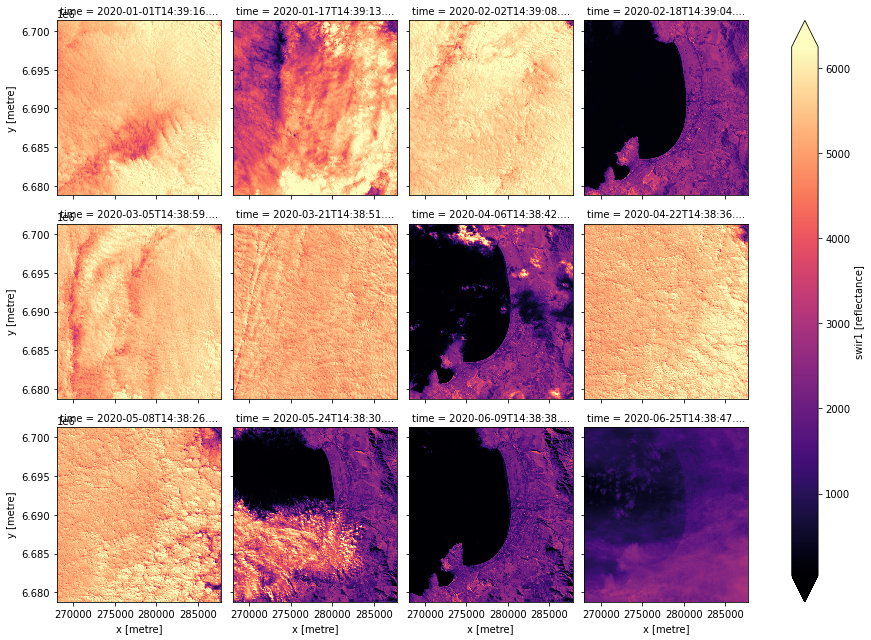

In [116]:
ds.swir1.plot(col="time", robust=True, cmap="magma", col_wrap=4)

## Plotting true or false colour RGB images

Although `xarray` makes it easy to plot single band images, plotting a three band colour photo-like image is less straightforward.

To make this easier, the the custom `rgb()` function that is designed for plotting three band images.
The `rgb()` function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.

Providing the `red`, `green` and `blue` measurements from a dataset will produce a true colour image (akin to how humans view the landscape).
Providing `nir`, `red` and `green` measurements or any other set of three satellite bands from a dataset will produce a false colour image. You can learn more about colour rendering [here](https://en.wikipedia.org/wiki/False_color#True_color).

Hence, the `rgb()` function can be used to visualise the data returned by a query.
It requires the minimum input of:

* `ds:` The `xarray.Dataset` object
* `bands:` Three bands for display (these must be measurements found in the dataset) 
* `index:` The timestep to view, default is `0`

### Plotting a single timestep

The time dimension of your `xarray.Dataset` describes how many timesteps exist for your location during your nominated time period.
In the `rgb()` function, the `index` variable is asking for which timestep you want to view (similar to the `isel()` example above).
Remember: counting in Python begins at 0 so to view the earliest timestep set `index=0`. In this example, we use `index=3`, which is the first cloud-free image shown above:

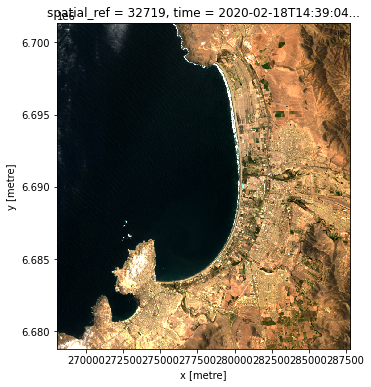

In [117]:
# View a red, green, blue (true colour) image of the first timestep
rgb(ds, bands=["red", "green", "blue"], index=3)

By changing the input bands, we can plot a false colour image which can provide different insights in a landscape.
This band combination (`swir1`, `nir`, `green`) emphasises growing vegetation in green, and water in deep blue:

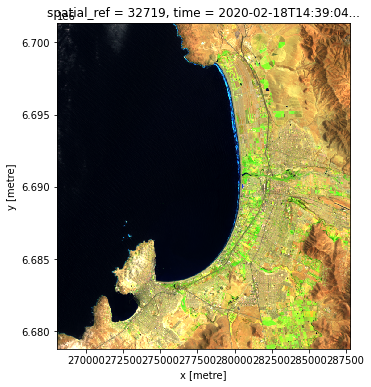

In [118]:
# View a swir1, nir, green (false colour) image of the first timestep
rgb(ds, bands=['swir1', 'nir', 'green'], index=3)

### Plotting multiple timesteps
As discussed in the [single band example above](#Plotting-multiple-timesteps), it can be useful to visualise multiple timesteps in a single plot (e.g. to compare change over time).

The `rgb()` function allows you to do this by providing a list of multiple images to plot using `index=[X, X, ...]`.
For example, we can plot the fourth and eleventh image in our dataset using `index=[3, 10]` (remembering that counting in Python starts at 0):

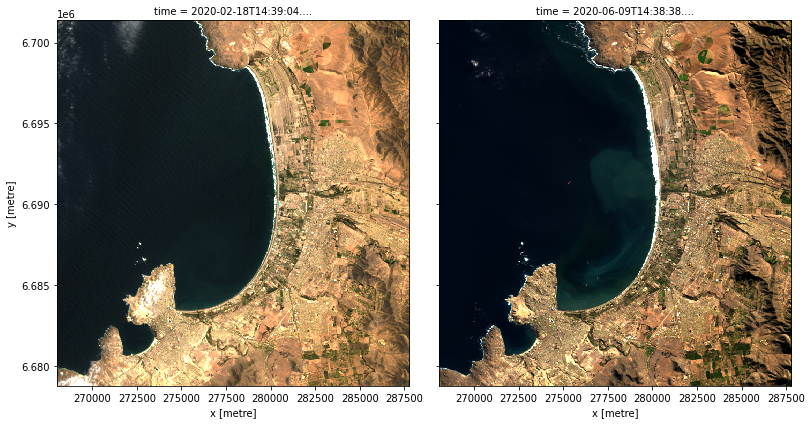

In [121]:
# View a true colour image for the third and tenth timesteps
rgb(ds, bands=['red', 'green', 'blue'], index=[3, 10])

It is also possible to use `rgb()` to plot all timesteps in a dataset using the `col="time"` syntax we demonstrate in the [single band example above](#Plotting-multiple-timesteps): 

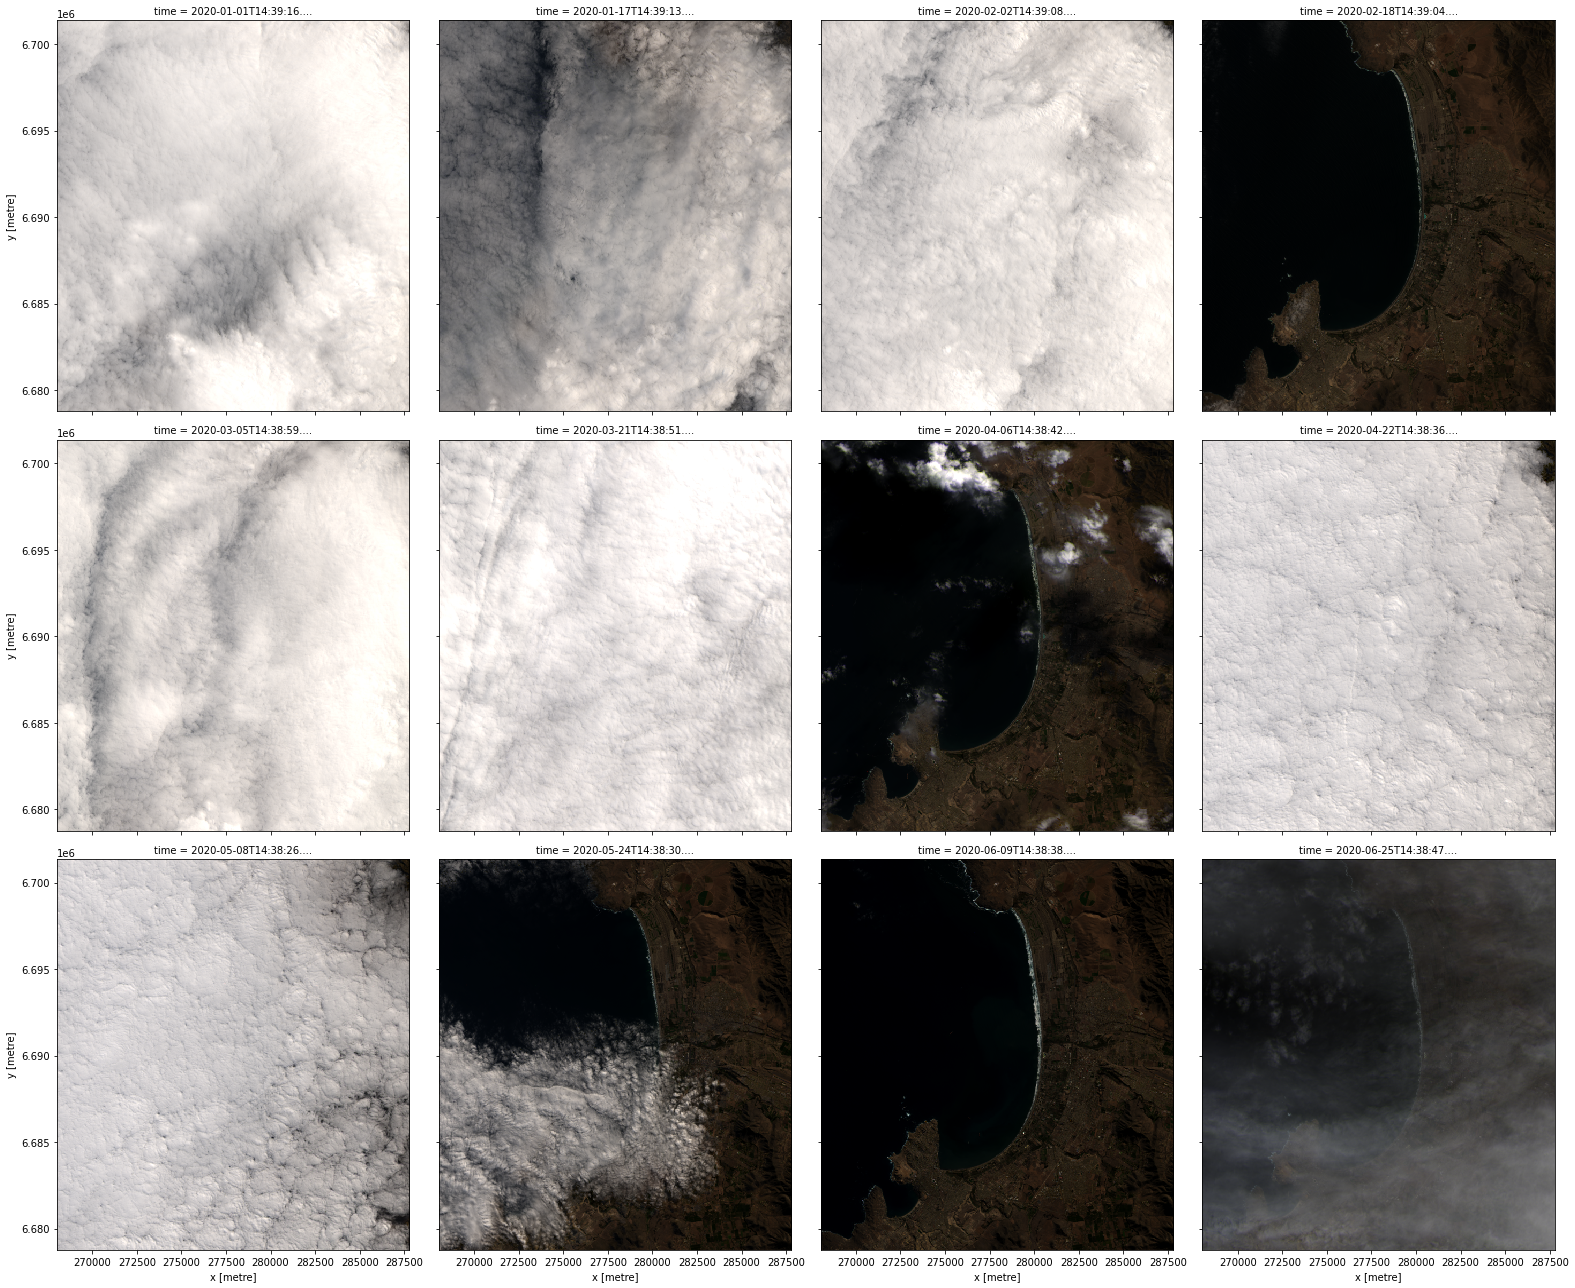

In [122]:
# Plot all timesteps in the dataset
rgb(ds, bands=['red', 'green', 'blue'], col="time")

### Customising plot appearance
By default, `rgb()` generates plots with `robust=True` to improve the appearance of the images by clipping out the darkest and brightest 2% of pixels, using the 2nd and 98th percentiles of the data to compute the color limits.

If this default provides poor results, the plot's colour stretch can be customised using the `percentile_stretch` parameter. 
This allows you to clip the most extreme minimum and maximum values in the dataset, to improve the contrast and appearance of the plot.

For example, specifying `percentile_stretch=[0.05, 0.95]` will clip out the darkest and brightest 5% of pixels, focusing the colour stretch on the remaining 90% of less extreme values:

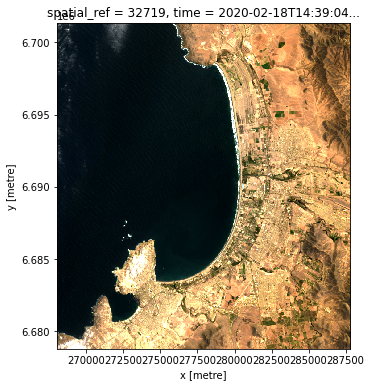

In [123]:
rgb(ds, 
    bands=['red', 'green', 'blue'], 
    index=3, 
    percentile_stretch=[0.05, 0.95])


## Recommended next steps

For more advanced information about working with Jupyter Notebooks or JupyterLab, you can explore [JupyterLab documentation page](https://jupyterlab.readthedocs.io/en/stable/user/notebook.html).

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](01_Jupyter_notebooks.ipynb)
2. [Products and Measurements](02_Products_and_measurements.ipynb)
3. [Loading data (this notebook)](03_Loading_data.ipynb)
4. **Plotting (this notebook)**
5. [Performing a basic analysis](05_Basic_analysis.ipynb)
6. [Introduction to numpy](06_Intro_to_numpy.ipynb)
7. [Introduction to xarray](07_Intro_to_xarray.ipynb)
8. [Parallel processing with Dask](08_Parallel_processing_with_dask.ipynb)